# Plot results of S-LDSC for single annotation model (LD model + 1 organsp annotation)

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_ldsc_enrichment(
    df,
    trait,
    x="Enrichment",
    xerr="Enrichment_std_error",
    organ_col="Organ",
    row_order=None,
    palette="tab10",
    ci_mult=1.96, # 95% CI if using SE
    xlim=None,
    figsize=(4, 3),
    enriched_filter=False,
    log2transform=False,
    save_path=None,
):
    """
    Horizontal dot+errorbar plot of LDSC enrichments for a single trait
    across organ-specific TLand scores (rows).
    """
    
    # Filter for specific trait
    trait_df = df[df["Trait"] == trait].copy()
    
    if trait_df.empty:
        raise ValueError(f"No data found for trait '{trait}'")
    
    # Build CI from SE
    trait_df["x_lower"] = trait_df[x] - ci_mult * trait_df[xerr]
    trait_df["x_upper"] = trait_df[x] + ci_mult * trait_df[xerr]

    if enriched_filter:
        trait_df = trait_df[~((trait_df["x_lower"] <= 1) & (trait_df["x_upper"] >= 1))]
        trait_df = trait_df[~(trait_df[x] < 1)]
    
    # Apply log2 transformation if requested
    if log2transform:
        trait_df[x] = np.log2(trait_df[x])
        trait_df["x_lower"] = np.log2(trait_df["x_lower"])
        trait_df["x_upper"] = np.log2(trait_df["x_upper"])
    
    if trait_df.empty:
        raise ValueError(f"No data remaining after filtering for trait '{trait}'")
    
    # Order organ-specific TLand scores (y) – if not provided, order by mean enrichment
    if row_order is None:
        row_order = (
            trait_df.groupby(organ_col)[x]
                    .mean()
                    .sort_values(ascending=True)
                    .index.tolist()
        )
    else:
        # Filter row_order to only include organs present in filtered data
        row_order = [organ for organ in row_order if organ in trait_df[organ_col].values]
    
    # Color mapping per organ-specific TLand score
    unique_organs = list(dict.fromkeys(row_order))  # keep order
    palette_colors = sns.color_palette(palette, n_colors=len(unique_organs))
    organ_to_color = dict(zip(unique_organs, palette_colors))
    
    # Create single plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Ensure categorical y in desired order
    y = pd.Categorical(trait_df[organ_col], categories=row_order, ordered=True)
    y_pos = y.codes
    
    # Draw error bars
    for i, row in trait_df.iterrows():
        ax.errorbar(
            x=row[x], y=y_pos[list(trait_df.index).index(i)],
            xerr=ci_mult * row[xerr] if not log2transform else [[row[x] - row["x_lower"]], [row["x_upper"] - row[x]]],
            fmt="o", ms=6,
            mfc=organ_to_color[row[organ_col]],
            mec="black", mew=0.5, ecolor=organ_to_color[row[organ_col]],
            capsize=3, lw=1
        )
    
    # Y tick labels
    ax.set_yticks(range(len(row_order)))
    ax.set_yticklabels(row_order, fontsize=8)
    
    # Reference line at enrichment = 1 (or 0 in log2 space)
    ref_line = 0 if log2transform else 1.0
    ax.axvline(ref_line, ls=":", color="crimson", lw=1)
    
    ax.grid(True, axis="x", ls="--", alpha=0.3)
    xlabel = "Log2 Enrichment" if log2transform else "Enrichment"
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Organ")
    ax.set_title(f"{trait}", fontsize=10)
    
    # Set x-limits
    if xlim is not None:
        ax.set_xlim(xlim)
    else:
        # expand to include all CIs
        xmin = np.nanmin(trait_df["x_lower"].values)
        xmax = np.nanmax(trait_df["x_upper"].values)
        pad = 0.05 * (xmax - xmin if np.isfinite(xmax - xmin) else 1)
        if log2transform:
            ax.set_xlim(0, xmax + pad)
        else:
            ax.set_xlim(0, xmax + pad)
    
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

    return trait_df

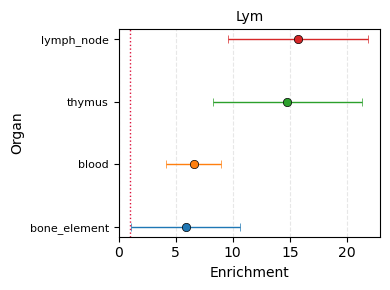

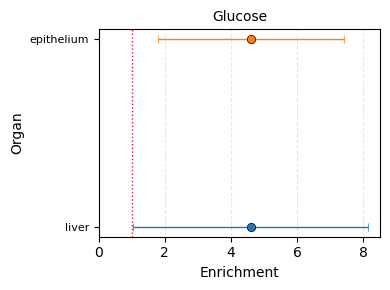

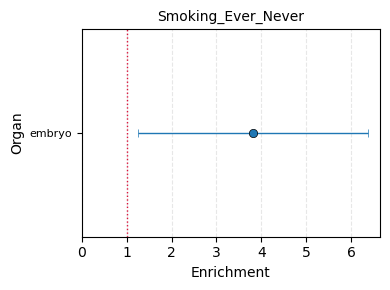

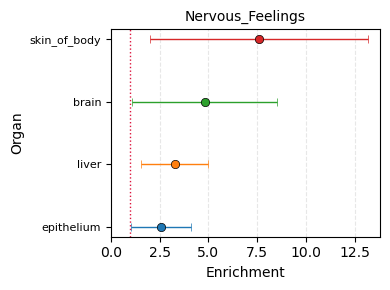

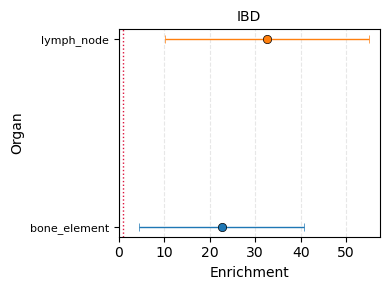

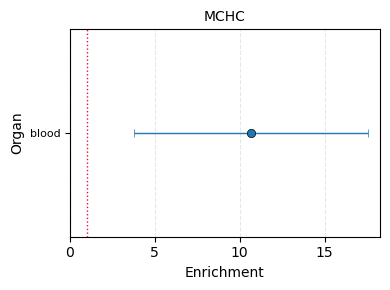

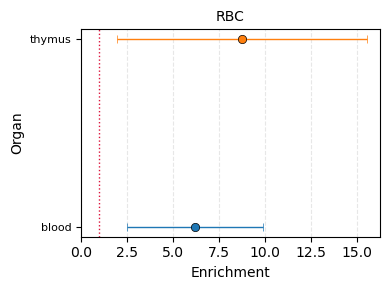

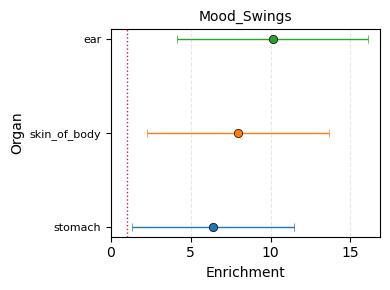

Error plotting Morning_Person: No data remaining after filtering for trait 'Morning_Person'


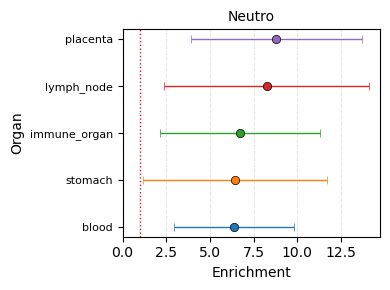

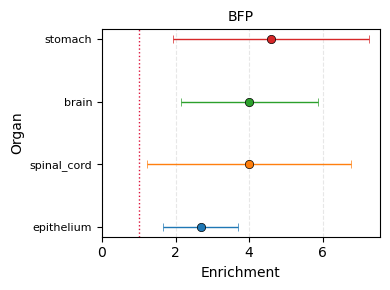

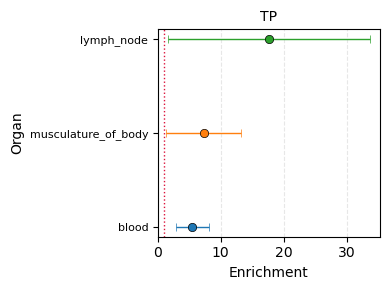

Error plotting LipoA: No data remaining after filtering for trait 'LipoA'


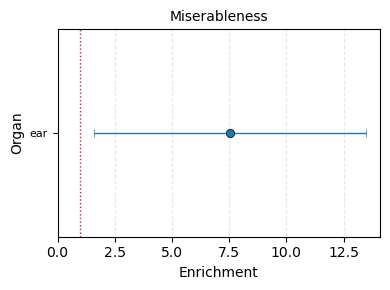

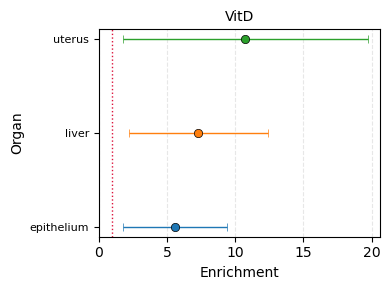

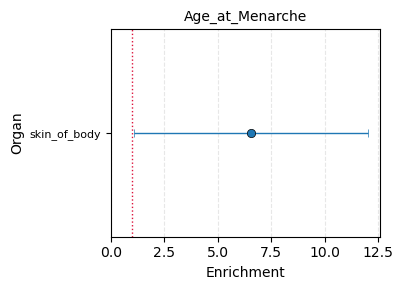

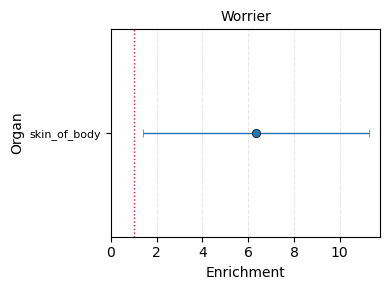

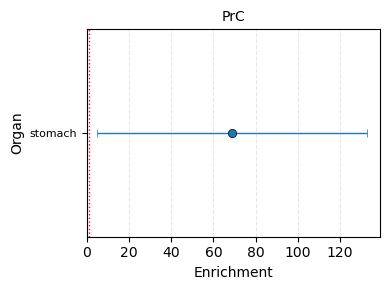

Error plotting CRP: No data remaining after filtering for trait 'CRP'


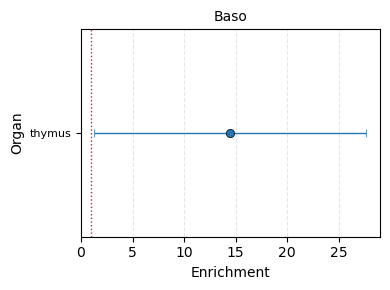

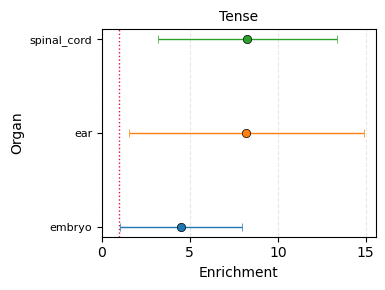

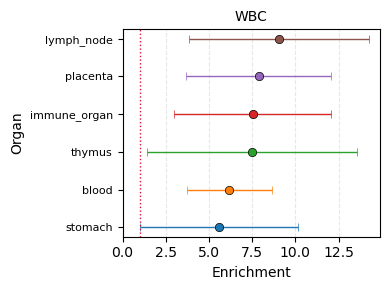

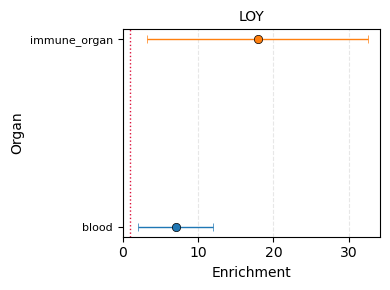

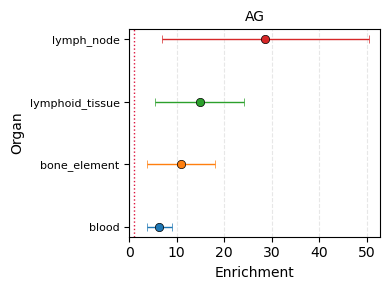

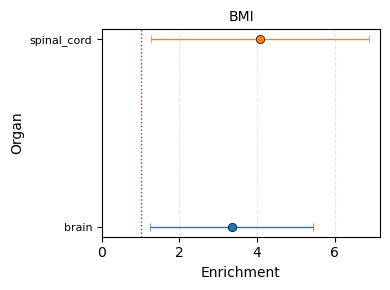

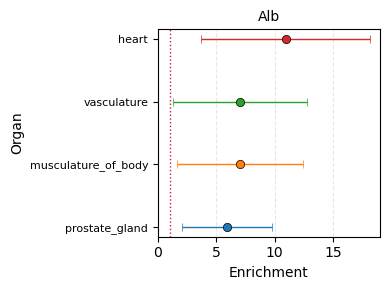

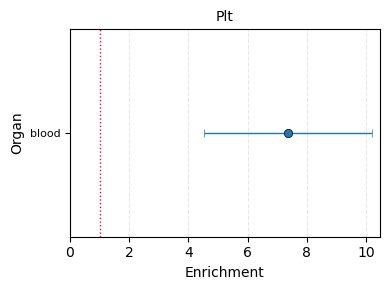

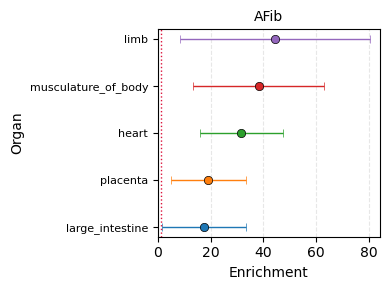

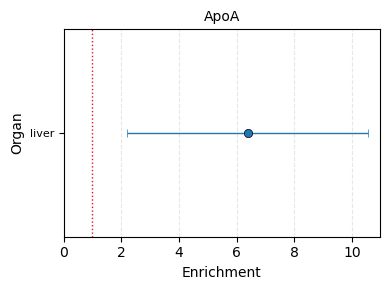

Error plotting Blood_Clot_Lung: No data remaining after filtering for trait 'Blood_Clot_Lung'


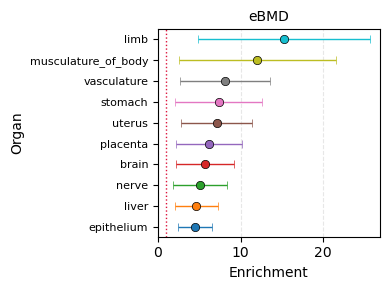

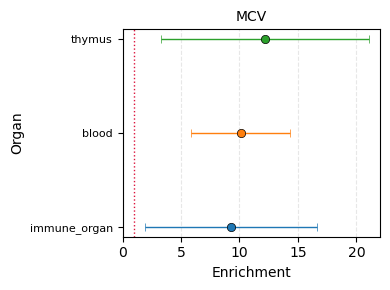

Error plotting Age_at_Menopause: No data remaining after filtering for trait 'Age_at_Menopause'


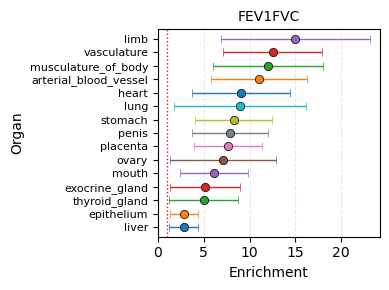

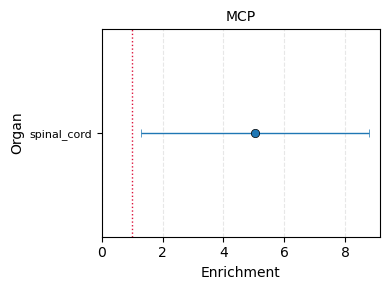

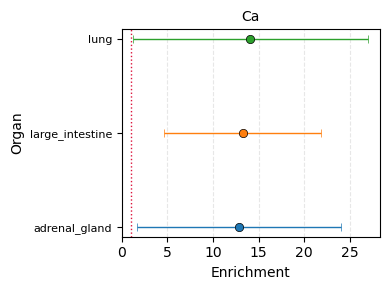

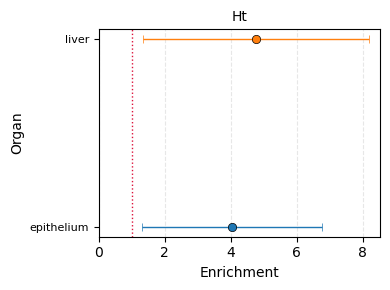

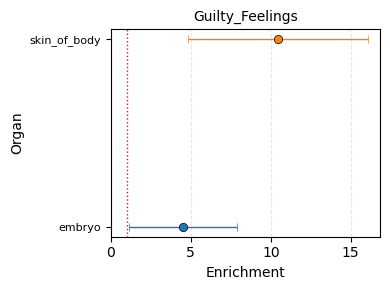

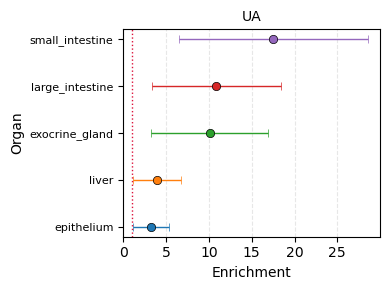

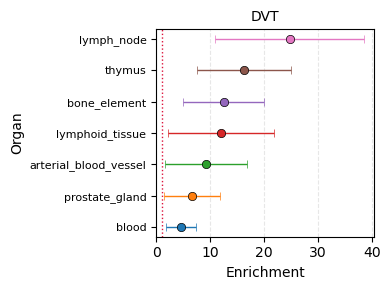

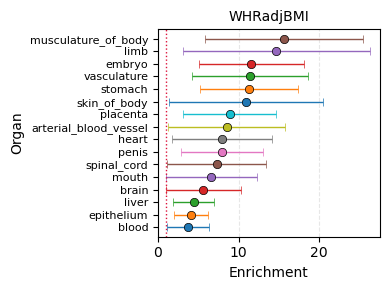

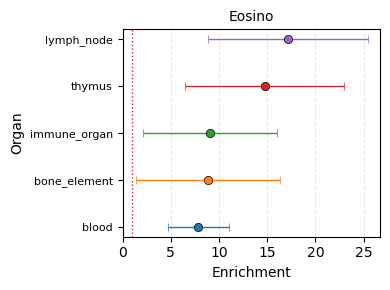

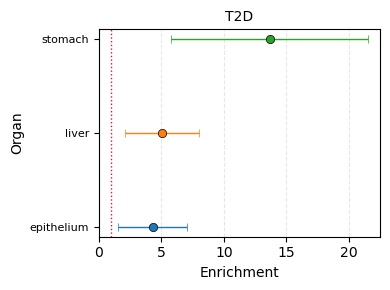

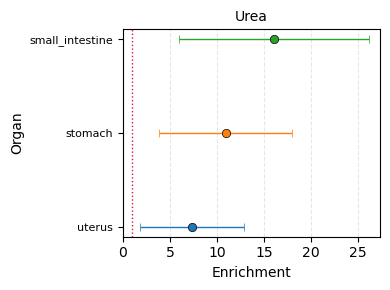

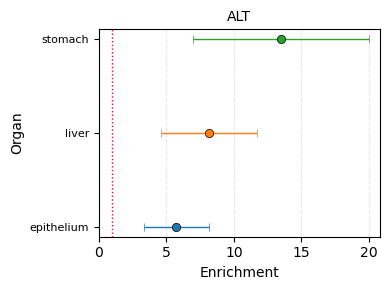

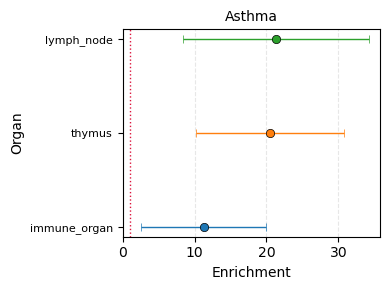

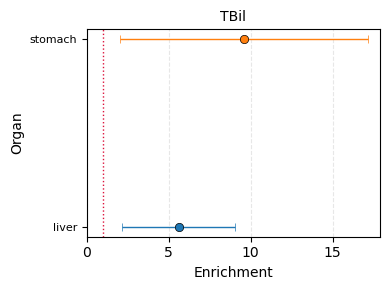

Error plotting Insomnia: No data remaining after filtering for trait 'Insomnia'


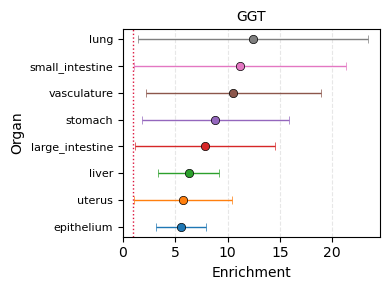

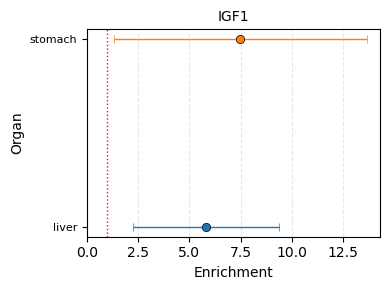

Error plotting Cholelithiasis: No data remaining after filtering for trait 'Cholelithiasis'
Error plotting ApoB: No data remaining after filtering for trait 'ApoB'
Error plotting Fibroblastic_Disorders: No data remaining after filtering for trait 'Fibroblastic_Disorders'


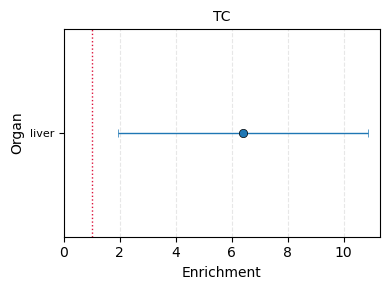

Error plotting Smoking_CPD: No data remaining after filtering for trait 'Smoking_CPD'


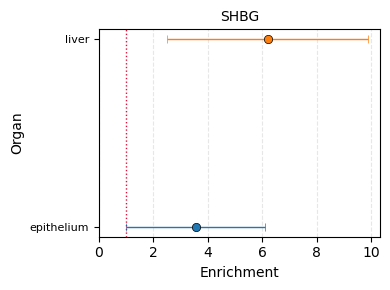

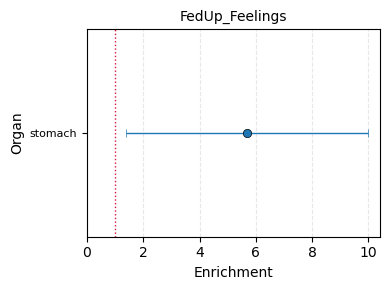

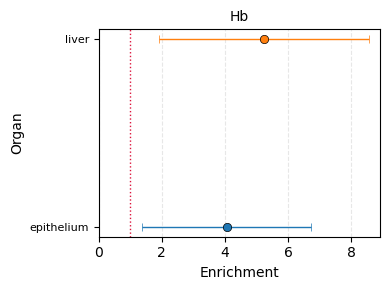

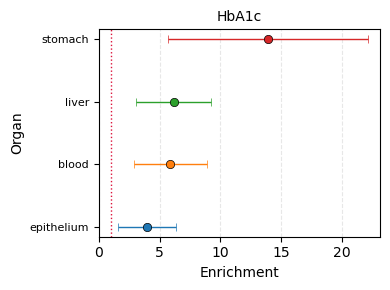

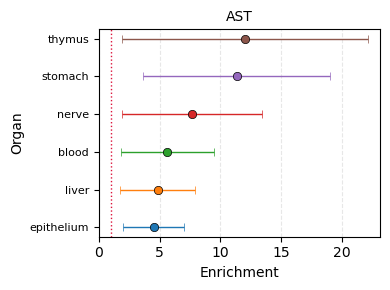

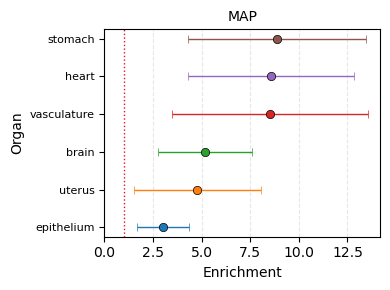

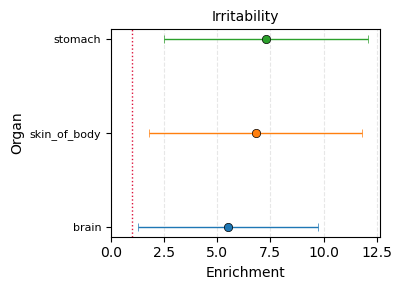

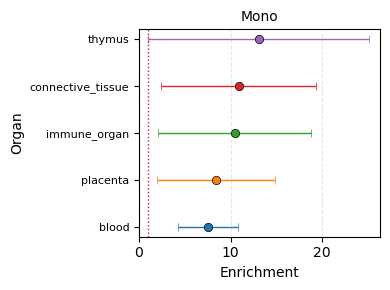

Error plotting BrC: No data remaining after filtering for trait 'BrC'


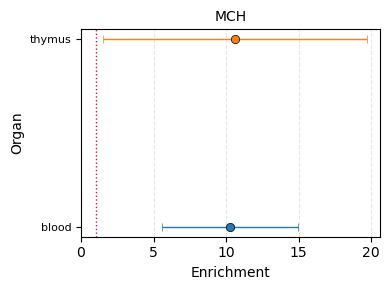

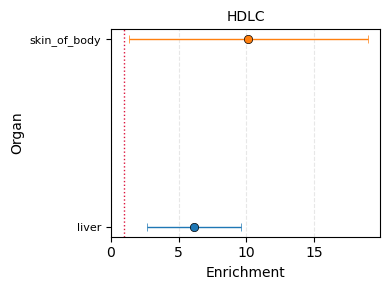

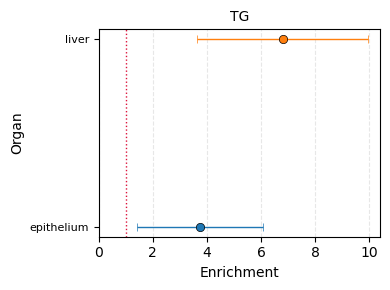

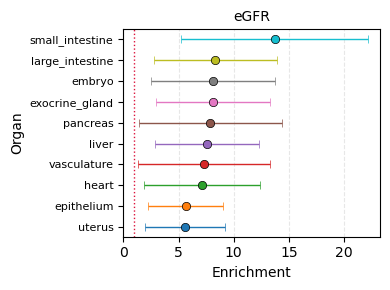

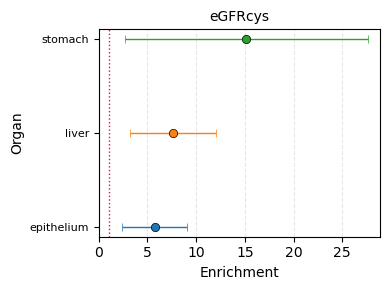

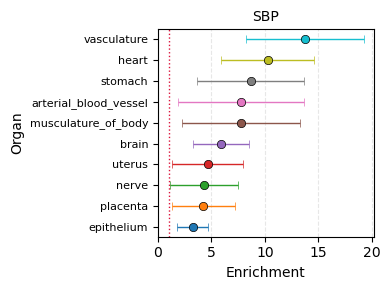

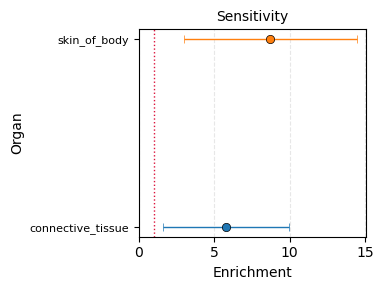

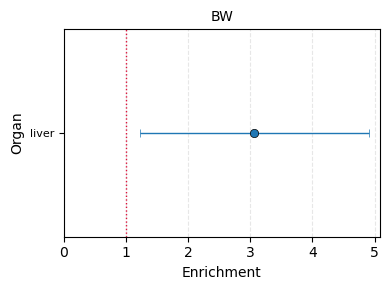

Error plotting Loneliness: No data remaining after filtering for trait 'Loneliness'


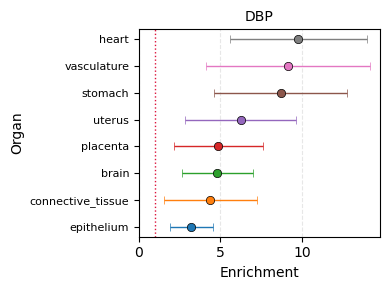

Error plotting Suffer_from_Nerves: No data remaining after filtering for trait 'Suffer_from_Nerves'
Error plotting Risk_Taking: No data remaining after filtering for trait 'Risk_Taking'
Error plotting CAD: No data remaining after filtering for trait 'CAD'


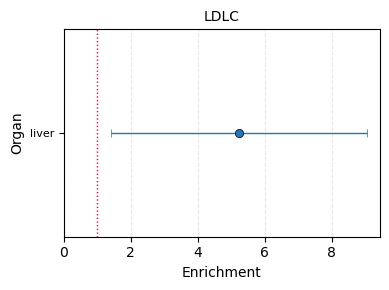

Error plotting CRC: No data remaining after filtering for trait 'CRC'


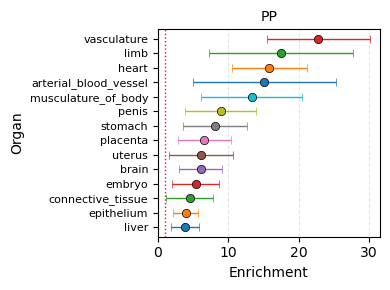

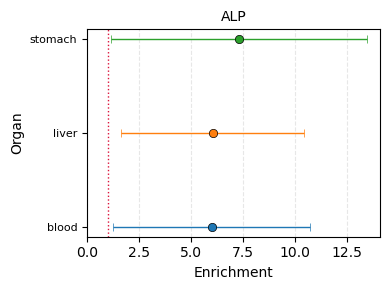

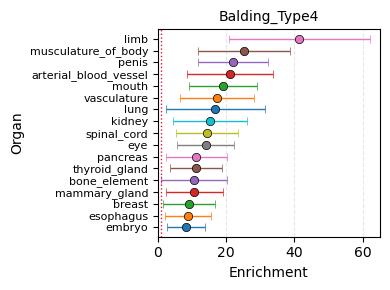

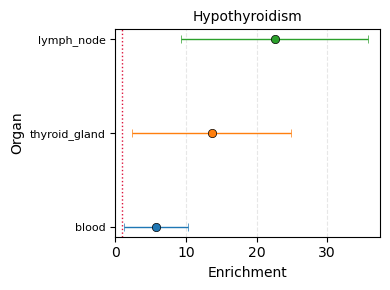

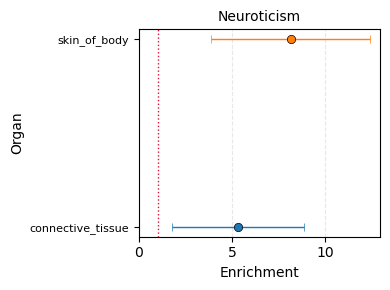

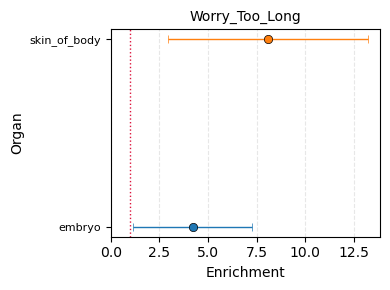

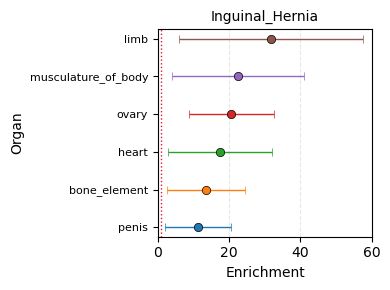

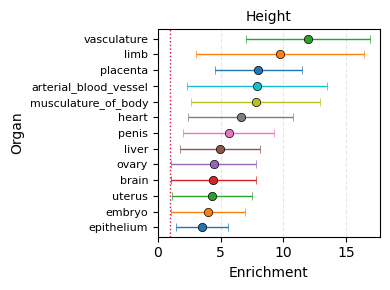

Plotted 71 traits successfully.


In [ ]:
binary_results_df = pd.read_csv('ukbb_data/tland_organsp_sldsc_results_annotated.csv')

trait_organ_dfs = []
trait_count = 0
for trait in binary_results_df['Trait'].unique():
    try:
        trait_df = plot_ldsc_enrichment(binary_results_df, trait=trait, organ_col='Organ', 
                                        enriched_filter=True, log2transform=False, save_path=f'figures/sldsc_enrichment/{trait}_enrichment.png')
        enriched_organs = trait_df[['Trait','Organ']]
        trait_organ_dfs.append(enriched_organs)
        trait_count += 1
    except Exception as e:
        print(f"Error plotting {trait}: {e}")
print(f"Plotted {trait_count} traits successfully.")

In [8]:
trait_organ_df = pd.concat(trait_organ_dfs, ignore_index=True)
trait_grouped_organs = trait_organ_df.groupby('Trait')['Organ'].apply(list)
trait_organ_summary_df = trait_grouped_organs.reset_index()
trait_organ_summary_df.columns = ['Trait', 'Organs']
trait_organ_summary_df.to_csv('organ_prio_results/trait_enriched_organs.tsv', sep='\t', index=False)

In [9]:
trait_organ_summary_df

,Trait,Organs
0,AFib,"[musculature_of_body, placenta, large_intestin..."
1,AG,"[blood, lymphoid_tissue, lymph_node, bone_elem..."
2,ALP,"[liver, blood, stomach]"
3,ALT,"[liver, epithelium, stomach]"
4,AST,"[liver, blood, epithelium, stomach, nerve, thy..."
...,...,...
66,Worrier,[skin_of_body]
67,Worry_Too_Long,"[skin_of_body, embryo]"
68,eBMD,"[liver, epithelium, stomach, musculature_of_bo..."
69,eGFR,"[liver, epithelium, exocrine_gland, large_inte..."
